Saad Mufti


CS 539 - HW 4

# **Conceptual and Theoretical Questions**

### **Q1 (8 pts)**
Because we are trying to estimate the parameters $w$ in a maximum likelihood problem, the Expectation Maximization (EM) algorithm may be used to find $\hat{w}$. In this specific case of finding $\hat{w}$ in an HMM problem, we can use the Baum-Welch algorithm, a special case of the EM algorithm.

First, perform the forward-backward procedure. The forward procedure is calculating the probability of observing the observed values from $1$ to some $t$, as well as the $t$ step of the hidden variable, given some initialized state of parameters $w_i$. 

In the backwards-procedure, calculate the probability of seeing the same observed sequence given the hidden variable and $w_i$.

Finally, perform the update step of the EM algorithm, using Bayes' theorem and the probabilities calculated using the forward-backward procedures. From this, the parameters of the HMM can be updated. 

### **Q2 (6 pts)**
With $\hat{f}$ defined by (11.2):
$$\hat{f}=\frac{1}{L}\sum_{l}^{L}{f(z^{(l)})}$$

The expectation $E[\hat{f}]$ would be:
$$E[\hat{f}] = \frac{1}{L}\sum_{l}^{L}{E[f(z^{(l)})]}$$
$$=\frac{1}{L}\sum_{l}^{L}{E[f]}$$
$$=\frac{1}{L}({L \cdot E[f]})$$
$$=E[f]$$

---

We want to show $Var[\hat{f}] = \frac{1}{L} E[(f-E[\hat{f}])^2]$
Start with the definition of variance:
$$Var[\hat{f}] = E[(\hat{f} - E[\hat{f}])^2] = E[\hat{f}]^2-E[\hat{f}^2]$$

$E[f] = E[\hat{f}]$, so $E[f]^2=E[\hat{f}]^2$.

Evaluate $E[\hat{f}^2]$:
$$E[\hat{f}^2] = \left(\sum_l^L{f^2(z^l)}\right)^2 = \sum_l^L{f^2(z^l)}$$
$$\hat{f}^2 = \sum_{i,j | i \neq j}^L{f(z^i)f(z^j)}+\sum_{l}^L{f^2(z^l)}$$
$$E[\hat{f}^2] = \frac{1}{L^2}E[f^2] + \frac{1}{L}\sum_{i,j | i \neq j}^L{E[f(z^i)f(z^j)]}$$
$$E[\hat{f}^2] = \frac{1}{L}E[f^2] + \sum_{i,j | i \neq j}^L{E[f(z^i)f(z^j)]}$$
$$E[\hat{f}^2] = \frac{1}{L}E[f^2] + \left(1-\frac{1}{L}\right)E[f]^2$$

Combine both these terms to get:
$$Var[\hat{f}] = \frac{1}{L} E[(f-E[\hat{f}])^2]$$

### **Q3 (6 pts)**
Here, we can use Equation (11.5) to find $p(y)$:

$$p(y) = p(z) \cdot \left|\frac{dz}{dy}\right|$$

Differentiate the inverse of the given equation of $y$ to find $\left|\frac{dz}{dy}\right|$:

$$\frac{y-c}{b}=\tan{z}$$
$$z=\tan^{-1}{\frac{y-c}{b}}$$

$$\frac{d}{dx}\tan^{-1}{x}=\frac{1}{1+x^2}$$
$$\left|\frac{dz}{dy}\right| = \frac{1}{1+{(\frac{y-c}{b})}^2}$$

As $z$ is a uniform distributon, $p(z)=b^{-1}$, so (11.5) becomes:

$$p(y) = \frac{b^{-1}}{1+{(\frac{y-c}{b})}^2}$$

Which roughly follows the form given by (11.16):
$$\frac{k}{1+\left(\frac{z-c}{b}\right)^2}$$

# **Application Questions**

In [2]:
# Imports
import numpy as np
from numpy import pi, sqrt, exp
import pandas as pd
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy import integrate

### **Viterbi Decoding Algorithm (20 pts)**

In [36]:
# Part a
obs_states = ["A", "C", "G", "T"]
hidden_states = ["H", "L"]
transition = np.array([
                [0.5, 0.4],
                [0.5, 0.6]
                ])
emission = np.array([
            [0.2, 0.3, 0.3, 0.2], 
            [0.3, 0.2, 0.2, 0.3]
            ])

def viterbi_alg(obs):
    N = len(obs)
    h_states = len(hidden_states)
    path_probs = np.zeros((h_states, N)) # 1st array is H probs, 2nd is L probs
    for i in range(0, N):    
        for k_index in range(len(hidden_states)): # k_index is either H (0) or L (1)
            nuc_idx = obs_states.index(obs[i])
            e_l = emission[k_index][nuc_idx]
            prev_p = path_probs.T[i - 1] if i > 0 else emission[:, nuc_idx]

            transition_prob = transition[:, k_index] if i > 0 else np.array([1.0 / h_states] * h_states)
            # k_prob = e_l * max(prev_p[0] * transition[0][k_index], 
            #                             prev_p[1] * transition[1][k_index])
            k_prob = e_l * max(prev_p[0] * transition_prob[0], prev_p[1] * transition_prob[1])
            path_probs[k_index][i] = k_prob
    
    mp_path = ""
    for probs in path_probs.T:
        # mx = np.array(np.argmax(probs)).reshape(1,)
        # print(probs)
        
        mx = np.argwhere(probs == np.amax(probs)).reshape(1,)
        # print(mx)
        # "X" means H and L are equilikely to appear in that position
        mp_path += hidden_states[mx[0]] if len(mx) == 1 else "X"
    print(mp_path)

viterbi_alg("GGCACTGAA")
_="""
Because of the extra precision in my calculations, compared to the example PDF, the path is slightly different (but equivalent).
"""

HHHLHLHLL


In [4]:
# Part b
viterbi_alg("AGTCGTA")

LHLHHLL


### **Bayesian Filtering (20 pts)**

In [3]:
# Part a
x_sim = [np.random.standard_normal()]
y_sim = []
for k in range(1, 101):
    x_sim.append(np.random.normal(0.99 * x_sim[k - 1] + 0.1, 0.1))
    y_sim.append(np.random.normal(-2 * x_sim[k] + 1, 0.4))


Text(0.5, 1.0, 'Posterior $p(x_k|y_{1..k})$ for $k=88$')

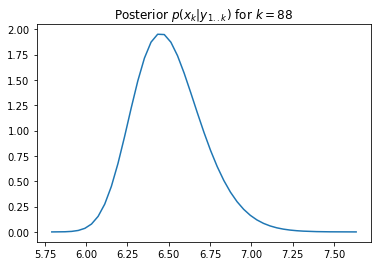

In [4]:
# Part b
post_x = np.linspace(-10, 10, num=500)
# print(post_x)
def posterior_prob(k, x, y=y_sim):
    assert k >= 1, "k must be greater than or equal to 1"
    # measure_model = lambda x_k: 1 / sqrt(0.4 * 2 * pi) * exp(-0.5 * (y[k - 1] - (-2 * x_k + 1)) ** 2 / 0.4)
    measure_model = 1 / sqrt(0.4 * 2 * pi) * exp(-0.5 * (y[k - 1] - (-2 * x + 1)) ** 2 / 0.4)
    def chap_kol():
        # dyn_mu = lambda x_k_prev: (0.99 * x_k_prev) + 0.1
        mu = (0.99 * x) + 0.1
        st_norm = norm.freeze(loc=0, scale=1)
        return integrate.cumulative_trapezoid(norm.pdf(x, loc=mu, scale=0.1) * 
                                    (posterior_prob(k - 1, x, y) if k > 1 else st_norm.pdf(x)), 
                                    x, initial=0)
    ck = chap_kol()
    z_k = integrate.trapezoid(measure_model * ck, x)
    return (1 / z_k) * measure_model * ck
    
k_sel = 88
post_y = posterior_prob(k_sel, post_x)
fig_post, ax_post = plt.subplots()
# print(integrate.trapezoid(post_y, post_x)) # Sanity check if you don't think the AUC of the PDF is 1
post_y[np.abs(post_y) < 1e-4] = np.nan
ax_post.plot(post_x, post_y)
ax_post.set_title(r"Posterior $p(x_k|y_{1..k})$ for " +  f"$k={k_sel}$")

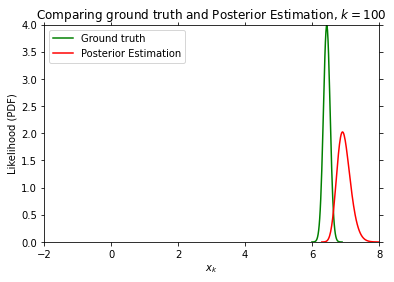

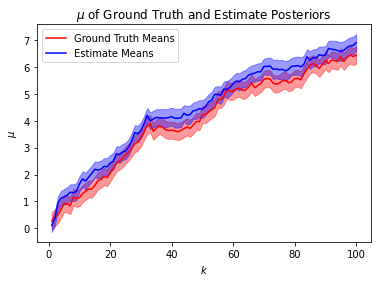

In [5]:
# Part c
gt_means = np.zeros(100)
gt_vars = np.array([0.1] * 100)
est_means = np.zeros(100)
est_vars = np.zeros(100)

fig_comp, ax_posterior = plt.subplots()
ax_posterior.set_xlim(-1, 8)
ax_posterior.set_ylim(0,4)

def posterior_vs_ground_truth(k, x=x_sim, y=y_sim):
    ax_posterior.clear()
    ax_posterior.set_xlim(-2, 8)
    ax_posterior.set_ylim(0,4)
    x_sam = np.linspace(-5, 9, num=900)

    ground_truth = norm.pdf(x_sam, loc=0.99 * x[k - 1] + 0.1, scale=0.1)
    ground_truth[np.abs(ground_truth) < 1e-4] = np.nan
    ax_posterior.plot(x_sam, ground_truth, label="Ground truth", color="green")
    gt_means[k - 1] = 0.99 * x[k - 1] + 0.1

    post_est = posterior_prob(k=k, x=x_sam, y=y)
    est_means[k - 1] = x_sam[np.argmax(post_est)]
    est_vars[k - 1] = np.nanvar(post_est)
    post_est[np.abs(post_est) < 1e-4] = np.nan
    ax_posterior.plot(x_sam, post_est, label="Posterior Estimation", color="red")

    ax_posterior.set_title(f"Comparing ground truth and Posterior Estimation, $k={k}$")
    ax_posterior.set_xlabel("$x_k$")
    ax_posterior.set_ylabel("Likelihood (PDF)")
    ax_posterior.legend()

fig_sum, ax_sum = plt.subplots()
for i in range(1,101):
    posterior_vs_ground_truth(i)
k_vals = np.arange(1, 101, step=1)
ax_sum.plot(k_vals, gt_means, label="Ground Truth Means", color="r")
ax_sum.fill_between(k_vals, gt_means + sqrt(gt_vars), gt_means - sqrt(gt_vars), color="r", alpha=0.4)
ax_sum.plot(k_vals, est_means, label="Estimate Means", color="b")
ax_sum.fill_between(k_vals, est_means + sqrt(est_vars), est_means - sqrt(est_vars), color="b", alpha=0.4)
ax_sum.set_xlabel("$k$")
ax_sum.set_ylabel(r"$\mu$")
ax_sum.set_title(r"$\mu$ of Ground Truth and Estimate Posteriors")
ax_sum.legend()

In [6]:
# For producing video animation of estimate vs ground truth
import matplotlib.animation as animation
plt.rcParams['animation.ffmpeg_path'] = "D:\\ffmpeg\\bin\\ffmpeg.exe"
anim = animation.FuncAnimation(
    fig_comp, lambda i: posterior_vs_ground_truth(i + 1, x_sim, y_sim), 
    frames=99, 
    interval=1000)

writervideo = animation.FFMpegWriter(fps=5) 
anim.save("posteriors_pt_b.mp4", writer=writervideo)

100


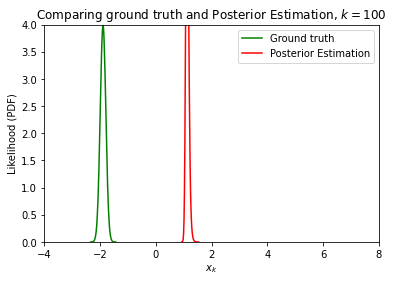

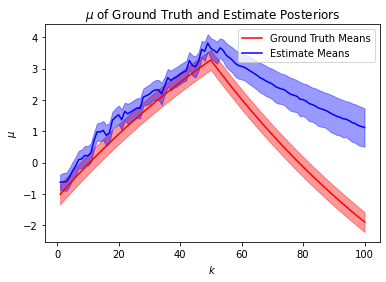

In [26]:
# Part d

df_filter = pd.read_excel("filter_problem.xlsx", header=None, names=["index", "x", "y"])
x_filter = df_filter["x"].to_numpy()
y_filter = df_filter["y"].dropna().to_numpy()
print(len(y_filter))

gt_means_d = np.zeros(100)
gt_vars_d = np.array([0.1] * 100)
est_means_d = np.zeros(100)
est_vars_d = np.zeros(100)

fig_d, ax_d = plt.subplots()

def posterior_vs_ground_truth_d(k, x=x_filter, y=y_filter):
    ax_d.clear()
    ax_d.set_xlim(-4, 8)
    ax_d.set_ylim(0,4)
    x_sam = np.linspace(-5, 9, num=900)

    ground_truth = norm.pdf(x_sam, loc=0.99 * x[k - 1] + 0.1, scale=0.1)
    ground_truth[np.abs(ground_truth) < 1e-4] = np.nan
    ax_d.plot(x_sam, ground_truth, label="Ground truth", color="green")
    gt_means_d[k - 1] = 0.99 * x[k - 1] + 0.1

    post_est = posterior_prob(k=k, x=x_sam, y=y)
    est_means_d[k - 1] = x_sam[np.argmax(post_est)]
    est_vars_d[k - 1] = np.nanvar(post_est)
    post_est[np.abs(post_est) < 1e-4] = np.nan
    ax_d.plot(x_sam, post_est, label="Posterior Estimation", color="red")

    ax_d.set_title(f"Comparing ground truth and Posterior Estimation, $k={k}$")
    ax_d.set_xlabel("$x_k$")
    ax_d.set_ylabel("Likelihood (PDF)")
    ax_d.legend()

# posterior_vs_ground_truth_d(99, x=x_filter, y=y_filter)

fig_sum_d, ax_sum_d = plt.subplots()
for i in range(1,101):
    posterior_vs_ground_truth_d(i, x=x_filter, y=y_filter)
k_vals = np.arange(1, 101, step=1)
ax_sum_d.plot(k_vals, gt_means_d, label="Ground Truth Means", color="r")
ax_sum_d.fill_between(k_vals, gt_means_d + sqrt(gt_vars_d), gt_means_d - sqrt(gt_vars_d), color="r", alpha=0.4)
ax_sum_d.plot(k_vals, est_means_d, label="Estimate Means", color="b")
ax_sum_d.fill_between(k_vals, est_means_d + sqrt(est_vars_d), est_means_d - sqrt(est_vars_d), color="b", alpha=0.4)
ax_sum_d.set_xlabel("$k$")
ax_sum_d.set_ylabel(r"$\mu$")
ax_sum_d.set_title(r"$\mu$ of Ground Truth and Estimate Posteriors")
ax_sum_d.legend()

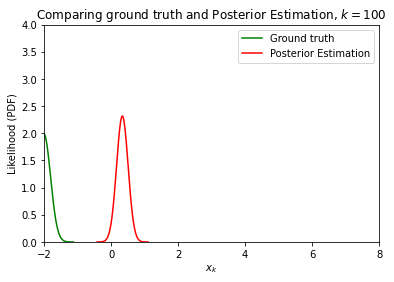

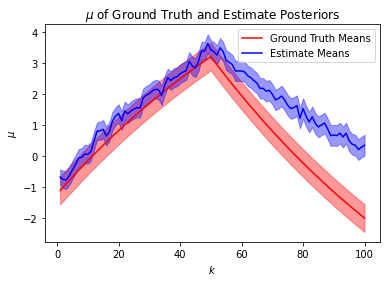

In [91]:
# Part e

gt_means_e = np.zeros(100)
gt_vars_e = np.array([0.2] * 100)
est_means_e = np.zeros(100)
est_vars_e = np.zeros(100)

def posterior_prob_e(k, x, y=y_filter):
    assert k >= 1, "k must be greater than or equal to 1"
    # measure_model = lambda x_k: 1 / sqrt(0.4 * 2 * pi) * exp(-0.5 * (y[k - 1] - (-2 * x_k + 1)) ** 2 / 0.4)
    measure_model = 1 / sqrt(0.4 * 2 * pi) * exp(-0.5 * (y[k - 1] - (-2 * x + 1)) ** 2 / 0.4)
    def chap_kol():
        st_norm = norm.freeze(loc=0, scale=1)

        norm_funcs = np.zeros((len(x), len(x)))
        for loc, i in enumerate(x):
            norm_funcs[loc] = norm.pdf(i, loc=x, scale=0.2)
        rec_res = posterior_prob(k - 1, x, y) if k > 1 else st_norm.pdf(x)
        return np.matmul(norm_funcs, rec_res.T)
        # return integrate.cumulative_trapezoid(norm.pdf(x, loc=x, scale=0.2) * 
        #                             (posterior_prob_e(k - 1, x, y) if k > 1 else st_norm.pdf(x)), 
        #                             x, initial=0)
    ck = chap_kol()
    z_k = integrate.trapezoid(measure_model * ck, x)
    return (1 / z_k) * measure_model * ck

fig_e, ax_e = plt.subplots()
def posterior_vs_ground_truth_e(k, x=x_filter, y=y_filter):
    ax_e.clear()
    ax_e.set_xlim(-2, 8)
    ax_e.set_ylim(0, 4)
    x_sam = np.linspace(-5, 9, num=900)

    ground_truth = norm.pdf(x_sam, loc=x[k - 1], scale=0.2)
    ground_truth[np.abs(ground_truth) < 1e-4] = np.nan
    ax_e.plot(x_sam, ground_truth, label="Ground truth", color="green")
    gt_means_e[k - 1] = x[k - 1]

    post_est = posterior_prob_e(k=k, x=x_sam, y=y)
    est_means_e[k - 1] = x_sam[np.argmax(post_est)]
    est_vars_e[k - 1] = np.nanvar(post_est)
    post_est[np.abs(post_est) < 1e-4] = np.nan
    ax_e.plot(x_sam, post_est, label="Posterior Estimation", color="red")

    ax_e.set_title(f"Comparing ground truth and Posterior Estimation, $k={k}$")
    ax_e.set_xlabel("$x_k$")
    ax_e.set_ylabel("Likelihood (PDF)")
    ax_e.legend()


posterior_prob_e(k=1, x=np.linspace(-10,10,num=900))
fig_sum_, ax_sum = plt.subplots()
for i in range(1,101):
    posterior_vs_ground_truth_e(i, x=x_filter, y=y_filter)
k_vals = np.arange(1, 101, step=1)
ax_sum.plot(k_vals, gt_means_e, label="Ground Truth Means", color="r")
ax_sum.fill_between(k_vals, gt_means_e + sqrt(gt_vars_e), gt_means_e - sqrt(gt_vars_e), color="r", alpha=0.4)
ax_sum.plot(k_vals, est_means_e, label="Estimate Means", color="b")
ax_sum.fill_between(k_vals, est_means_e + sqrt(est_vars_e), est_means_e - sqrt(est_vars_e), color="b", alpha=0.4)
ax_sum.set_xlabel("$k$")
ax_sum.set_ylabel(r"$\mu$")
ax_sum.set_title(r"$\mu$ of Ground Truth and Estimate Posteriors")
ax_sum.legend()


#### **Part f**
In part c, the estimated posterior distributions closely matched the simulated data produced by the state and measurement models, although they did consistently overestimate by a small amount. This can also be seen in the video "posteriors_pt_b.mp4".

In part d, the model begins by closely estimating the ground truth data, but the posteriors do not translate leftwards as fast as the data does. 

In part e, the same pattern occurs, but with overall higher accuracy.

### **Sequential MCMC (20 pts)**

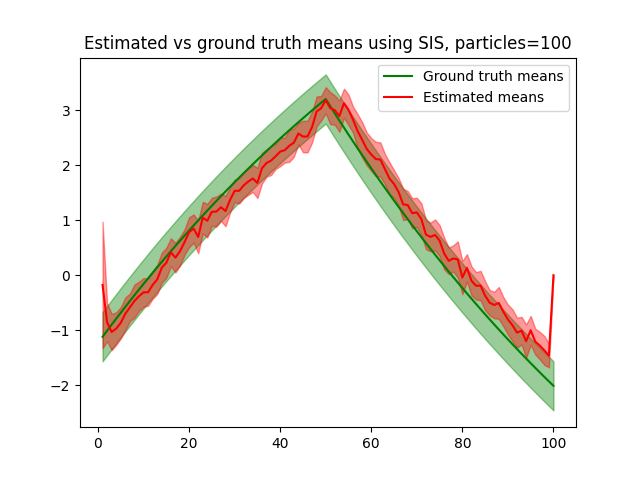

In [14]:
# Part a
df_filter = pd.read_excel("filter_problem.xlsx", header=None, names=["index", "x", "y"])
x_filter = df_filter["x"]
y_filter = df_filter["y"].dropna().to_numpy()
df_filter.head()

gt_means = np.zeros(100)
gt_vars = np.array([0.1] * 100)

def sis(particles, k_max):
    w = np.full((particles, k_max), 1.0 / particles) # weights, initialized to 1/particles
    x = np.zeros((particles, k_max))
    x[:, 0] = np.random.standard_normal(size=(particles,)) # Particles, initialized to x1
    means = np.zeros(k_max)
    vars = np.zeros(k_max)

    for k in range(1, k_max):
        # Note that our proposal distribution is equal to our dynamical model
        imp_particles = np.random.choice(x[:, k - 1], size=particles, p=w[:, k - 1])
        for i in range(particles):
            x[i, k] = np.random.normal(loc=imp_particles[i], scale=0.2)
            state_model = norm.pdf(x[i, k], x[i, k - 1], scale=0.2)
            measure_model = norm.pdf(y_filter[k - 1], loc=-2 * x[i][k - 1] + 1, scale=0.4)
            w[i, k] = measure_model * state_model
        w[:, k] /= sum(w[:, k])

        means[k - 1] = np.mean(x[:, k])
        vars[k - 1] = np.var(x[:, k])
    return means, vars


def compare_sis(ax, particles):
    x_sis = np.arange(1, 101, step=1)
    gt_means = x_filter[0:100]
    gt_vars = [0.2] * 100
    ax.plot(x_sis, gt_means, color="green", label="Ground truth means")
    ax.fill_between(x_sis, gt_means - sqrt(gt_vars), gt_means + sqrt(gt_vars), color="green", alpha=0.4)

    means_sis, vars_sis = sis(particles=particles, k_max=100)
    
    ax.plot(x_sis, means_sis, color="red", label="Estimated means")
    ax.set_title(f"Estimated vs ground truth means using SIS, particles={particles}")
    ax.fill_between(x_sis, means_sis + sqrt(vars_sis), means_sis - sqrt(vars_sis), color="red", alpha=0.4)
    ax.legend()

fig_sis, ax_sis = plt.subplots()
compare_sis(ax_sis, 100)
# For some reason, my plots for a and b of this question do not appear in my Jupyter Notebook export, so I have attached them separately in Canvas

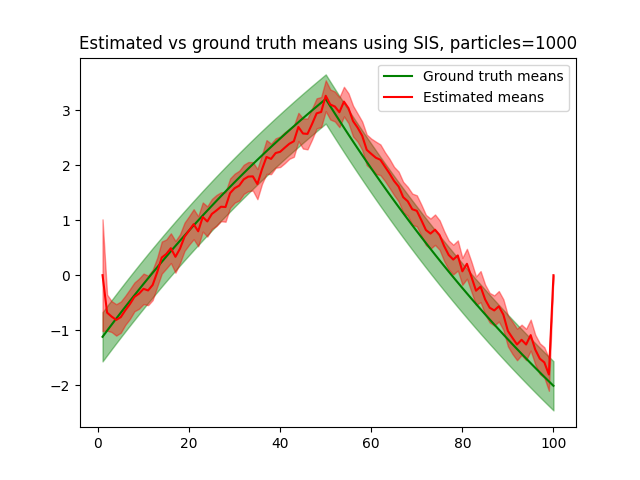

In [15]:
# Part b
fig_sis_b, ax_sis_b = plt.subplots()
compare_sis(ax_sis_b, 1000)

### **GP Linear Regression (20 pts)**

In [101]:
# Part a
df_sm = pd.read_csv("synchronous machine.csv",
                    delimiter=";",
                    decimal=",")
print(df_sm.head())
x_sm = df_sm.drop(columns=["If", "dIf"]).values
y_sm = df_sm["If"].values


def model_mse(model):
    train_mse = []
    test_mse = []
    for train_loc, test_loc in KFold(n_splits=10, shuffle=True).split(x_sm, y_sm):
        train_x, test_x = x_sm[train_loc], x_sm[test_loc]
        train_y, test_y = y_sm[train_loc], y_sm[test_loc]
        model_tmp = None
        if model == GaussianProcessRegressor:
            model_tmp = model(random_state=0)
        else: 
            model_tmp = model()
        model_tmp.fit(train_x, train_y)
        train_mse.append(mean_squared_error(model_tmp.predict(train_x), train_y))
        test_mse.append(mean_squared_error(model_tmp.predict(test_x), test_y))
    return train_mse, test_mse


gp_train_mse, gp_test_mse = model_mse(GaussianProcessRegressor)


    Iy    PF     e    dIf     If
0  3.0  0.66  0.34  0.383  1.563
1  3.0  0.68  0.32  0.372  1.552
2  3.0  0.70  0.30  0.360  1.540
3  3.0  0.72  0.28  0.338  1.518
4  3.0  0.74  0.26  0.317  1.497


In [102]:
# Part b
lin_model = LinearRegression()
lin_train_mse, lin_test_mse = model_mse(LinearRegression)
# print(lin_train_mse)

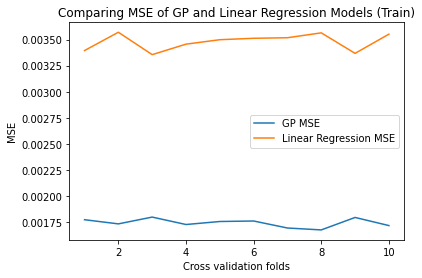

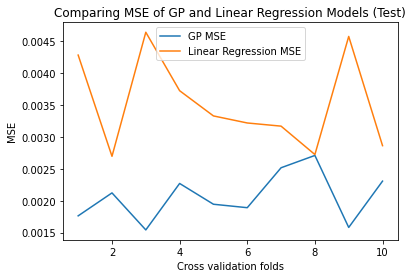

In [103]:
# Part c
err_x = np.arange(1, 11, step=1)

fig_comp, ax_comp = plt.subplots()
ax_comp.plot(err_x, gp_train_mse, label="GP MSE")
ax_comp.plot(err_x, lin_train_mse, label="Linear Regression MSE")
ax_comp.set_title("Comparing MSE of GP and Linear Regression Models (Train)")
ax_comp.set_xlabel("Cross validation folds")
ax_comp.set_ylabel("MSE")
ax_comp.legend()

fig_comp, ax_comp = plt.subplots()
ax_comp.plot(err_x, gp_test_mse, label="GP MSE")
ax_comp.plot(err_x, lin_test_mse, label="Linear Regression MSE")
ax_comp.set_title("Comparing MSE of GP and Linear Regression Models (Test)")
ax_comp.set_xlabel("Cross validation folds")
ax_comp.set_ylabel("MSE")
ax_comp.legend()

_="""
Evidently, the MSE in both the train and test datasets is lower for the Gaussian Process model, and higher in the Linear Regression model
"""